# Overview Seperate Chains
Overview when using a seperate model for the alpha chain and beta chain. The test data doesn't contain NaN's here.

| Model Alpha       | Model Beta        | AUC Alpha | AUC Beta | AUC Combined |
|-------------------|-------------------|-----------|----------|--------------|
| RF (mean imputed) | RF (mean imputed) | 0.890     | 0.911    | 0.954        |
| HistGradient      | HistGradient      | 0.922     | 0.917    | 0.967        |
| XGB               | XGB               | 0.916     | 0.929    | 0.967        |
| HistGradient      | XGB               | 0.922     | 0.929    | 0.966        |

## Data

In [27]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test, evaluate, calculate_auc_and_plot, get_columns_starting_with
import numpy as np
import pandas as pd

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

train, test = train_test_split(df, test_size=0.2, random_state=42)

test.dropna(inplace=True)
x = get_features(train)
y = train['reaction']
x_test = get_features(test, test=True)
x_test = fix_test(x_test, x.columns)
y_test = test['reaction']

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


## Evaluation

In [2]:
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import VotingClassifier

def evaluate_seperate_chains(clf1, clf2, x, y, x_test, y_test):
    # Keep only the columns starting with 'alfa_'
    x_alpha = get_columns_starting_with(x, 'alfa_')
    x_beta = get_columns_starting_with(x, 'beta_')

    clf1.fit(x_alpha, y)
    clf2.fit(x_beta, y)

    x_test_alpha = get_columns_starting_with(x_test, 'alfa_')
    x_test_beta = get_columns_starting_with(x_test, 'beta_')

    x_test_alpha = fix_test(x_test_alpha, x_alpha.columns)
    x_test_beta = fix_test(x_test_beta, x_beta.columns)

    y_pred1 = clf1.predict_proba(x_test_alpha)[:, 1]
    y_pred2 = clf2.predict_proba(x_test_beta)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1, pos_label=1)
    auc_alpha = metrics.auc(fpr, tpr)
    print(f"alpha: {auc_alpha:.3f}")

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred2, pos_label=1)
    auc_beta = metrics.auc(fpr, tpr)
    print(f"beta: {auc_beta:.3f}")

    y_pred = (y_pred1 + y_pred2) / 2
    auc = calculate_auc_and_plot(y_test, y_pred)

    print(f"combined: {auc:.3f}")
    return {
        'auc_alpha': auc_alpha,
        'auc_beta': auc_beta,
        'auc_combined': auc
    }

    # Code below doesn't work yet (since I still need to figure out how I can give two seperate input streams to the VotingClassifier)
    # # alpha model
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # scores = cross_val_score(clf1, x, y, cv=kf, scoring='roc_auc')
    # print(scores)
    # print(f"ROC alpha: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    #
    # # beta model
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # scores = cross_val_score(clf2, x, y, cv=kf, scoring='roc_auc')
    # print(scores)
    # print(f"ROC beta: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    #
    # # combined model
    # clf = VotingClassifier(estimators=[('alpha', clf1), ('beta', clf2)], voting='soft')
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # scores = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')
    # print(scores)
    # print(f"ROC combined: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

## Imputations

In [29]:
from sklearn import impute

### Mean imputed

In [33]:
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
x_mean_imputed = mean_imputer.fit_transform(x)
# convert it back to a df (so I can split the alpha and beta columns)
# get all columns of which not all rows are NaN
columns = x.columns[x.isnull().mean() < 1]
x_mean_imputed = pd.DataFrame(x_mean_imputed, columns=columns)

x_test_mean_imputed = mean_imputer.transform(x_test)
x_test_mean_imputed = pd.DataFrame(x_test_mean_imputed, columns=columns)

## Random Forest - Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
clf_alpha = RandomForestClassifier(random_state=0)
clf_beta = RandomForestClassifier(random_state=0)

alpha: 0.8902930154860265
beta: 0.9106325342001896


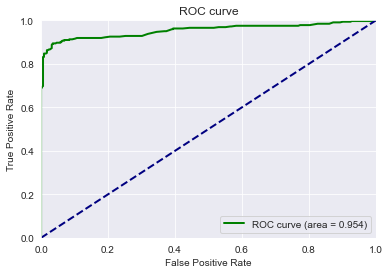

combined: 0.954


In [35]:
evaluate_seperate_chains(clf_alpha, clf_beta, x_mean_imputed, y, x_test_mean_imputed, y_test)

## HistGradientBoosting - HistGradientBoosting

In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_alpha = HistGradientBoostingClassifier(random_state=0)
clf_beta = HistGradientBoostingClassifier(random_state=0)

alpha: 0.9223712131473205
beta: 0.9170346291028941


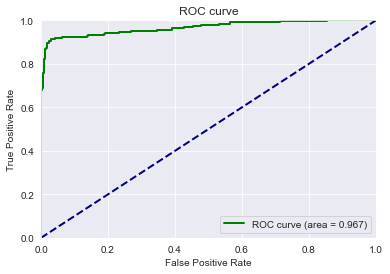

combined: 0.967


In [37]:
evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)

## XGBoost - XGBoost

In [38]:
from xgboost import XGBClassifier
clf_alpha = XGBClassifier(random_state=0)
clf_beta = XGBClassifier(random_state=0)

alpha: 0.9166373199692988
beta: 0.9285475642241185


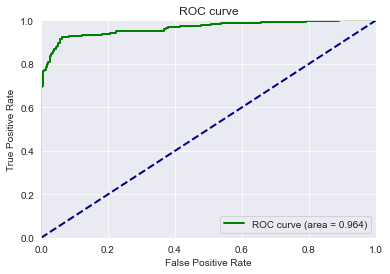

combined: 0.964


In [39]:
evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)

## HistGradientBoosting - XGBoost

In [43]:
clf_alpha = HistGradientBoostingClassifier(random_state=0)
clf_beta = XGBClassifier(random_state=0)

alpha: 0.922
beta: 0.929


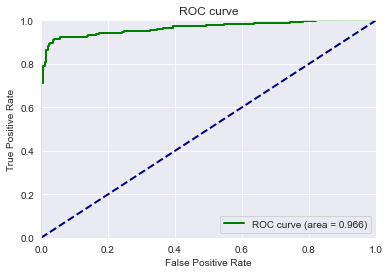

combined: 0.966


In [44]:
evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating RF
alpha: 0.889
beta: 0.913


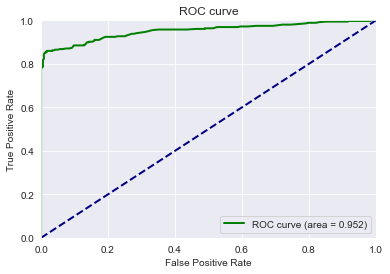

combined: 0.952
ROC AUC: 0.947



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating RF
alpha: 0.866
beta: 0.893


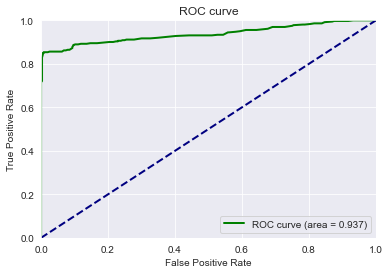

combined: 0.937
ROC AUC: 0.930



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating RF
alpha: 0.887
beta: 0.924


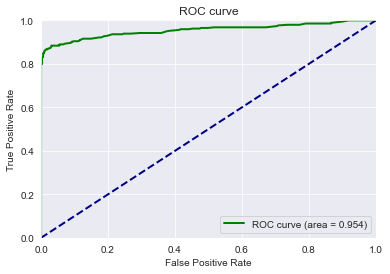

combined: 0.954
ROC AUC: 0.943



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating RF
alpha: 0.885
beta: 0.896


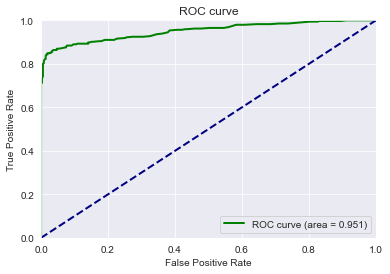

combined: 0.951
ROC AUC: 0.937



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating RF
alpha: 0.865
beta: 0.929


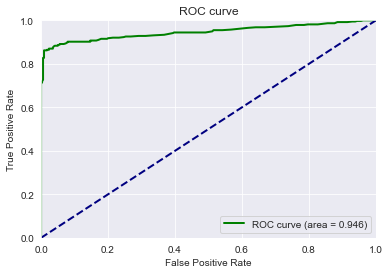

combined: 0.946
ROC AUC: 0.942



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating HistGB
alpha: 0.915
beta: 0.916


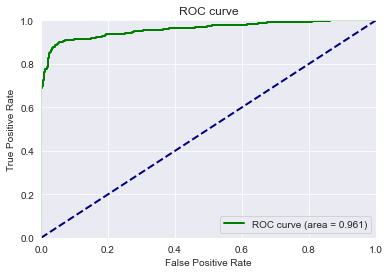

combined: 0.961
ROC AUC: 0.966



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating HistGB
alpha: 0.883
beta: 0.898


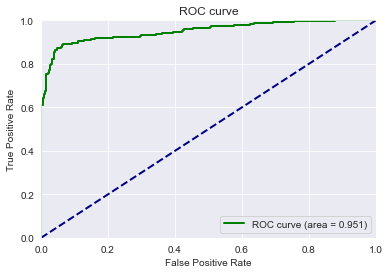

combined: 0.951
ROC AUC: 0.955



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating HistGB
alpha: 0.909
beta: 0.924


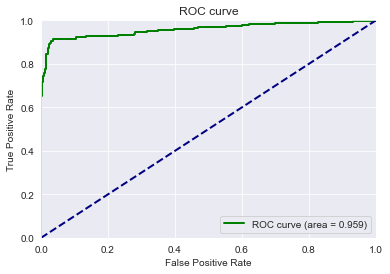

combined: 0.959
ROC AUC: 0.958



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating HistGB
alpha: 0.904
beta: 0.893


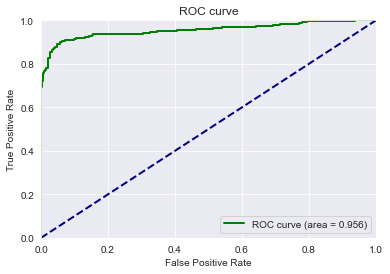

combined: 0.956
ROC AUC: 0.960



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating HistGB
alpha: 0.905
beta: 0.924


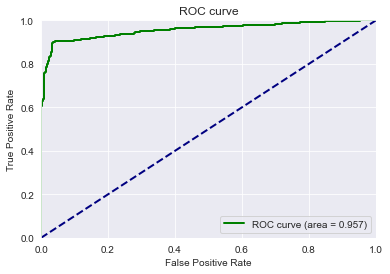

combined: 0.957
ROC AUC: 0.961



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating XGB
alpha: 0.915
beta: 0.918


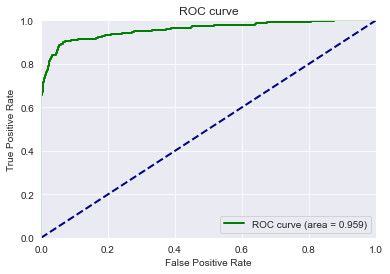

combined: 0.959
ROC AUC: 0.960



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating XGB
alpha: 0.884
beta: 0.897


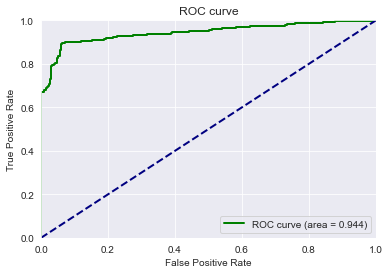

combined: 0.944
ROC AUC: 0.946



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating XGB
alpha: 0.898
beta: 0.927


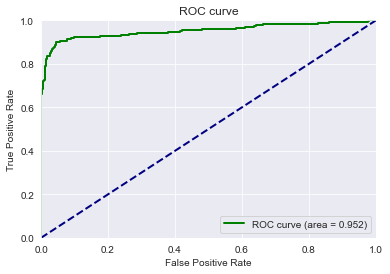

combined: 0.952
ROC AUC: 0.955



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating XGB
alpha: 0.895
beta: 0.895


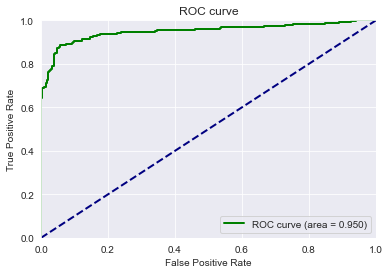

combined: 0.950
ROC AUC: 0.955



C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating XGB
alpha: 0.896
beta: 0.935


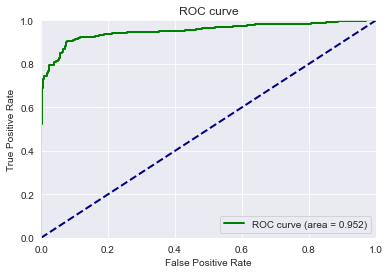

combined: 0.952
ROC AUC: 0.963



,model,chain,auc
0,RF,auc_alpha,0.889429
1,RF,auc_beta,0.912572
2,RF,auc_combined,0.952157
3,RF,together,0.946747
4,RF,auc_alpha,0.865560
5,RF,auc_beta,0.893341
6,RF,auc_combined,0.937411
7,RF,together,0.930454
8,RF,auc_alpha,0.887269
9,RF,auc_beta,0.923650


In [10]:
from util import evaluate_no_cv, get_train_dataset, get_features, fix_test, get_columns_starting_with, calculate_auc_and_plot
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd

models_to_evaluate = [
    {"name": "RF", "clf_generator": lambda: RandomForestClassifier(random_state=0), "drop_nan": True},
    {"name": "HistGB", "clf_generator": lambda: HistGradientBoostingClassifier(random_state=0), 'drop_nan': False},
    {"name": "XGB", "clf_generator": lambda: XGBClassifier(random_state=0), 'drop_nan': False},
]

folds = 5

df = get_train_dataset() #.sample(100)
# df = df.sample(n=1000) # for faster debugging

scores = pd.DataFrame()
for model in models_to_evaluate:
    for seed in range(folds):
        train, test = train_test_split(df, test_size=0.2, random_state=seed)

        if model['drop_nan']:
            train = train.dropna()

        test.dropna(inplace=True)
        x = get_features(train)
        y = train['reaction']
        x_test = get_features(test, test=True)
        x_test = fix_test(x_test, x.columns)
        y_test = test['reaction']

        clf_alpha = model["clf_generator"]()
        clf_beta = model["clf_generator"]()
        print(f"Evaluating {model['name']}")
        results = evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)
        for result in results:
            auc = results[result]
            scores = scores.append({
                "model": model["name"],
                "chain": result,
                "auc": auc
            }, ignore_index=True)
        auc_together = evaluate_no_cv(model["clf_generator"](), x, y, x_test, y_test)
        scores = scores.append({
            "model": model["name"],
            "chain": "together",
            "auc": auc_together
        }, ignore_index=True)
        print()

scores

In [12]:
baseline = scores[(scores['model'] == 'RF') & (scores['chain'] == 'together')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline
scores

,model,chain,auc,improvement
0,RF,auc_alpha,0.889429,-0.050338
1,RF,auc_beta,0.912572,-0.027196
2,RF,auc_combined,0.952157,0.012389
3,RF,together,0.946747,0.006979
4,RF,auc_alpha,0.865560,-0.074207
5,RF,auc_beta,0.893341,-0.046427
6,RF,auc_combined,0.937411,-0.002357
7,RF,together,0.930454,-0.009314
8,RF,auc_alpha,0.887269,-0.052499
9,RF,auc_beta,0.923650,-0.016118


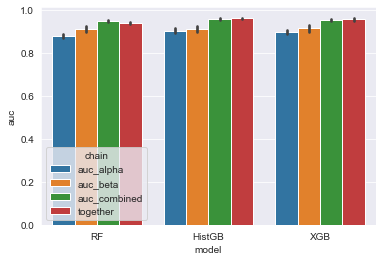

In [15]:
import seaborn as sns
plot = sns.barplot(x="model", y="auc", data=scores, ci="sd", hue="chain")
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
pass

C:\Users\arnod\AppData\Local\Temp/ipykernel_10608/160773030.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


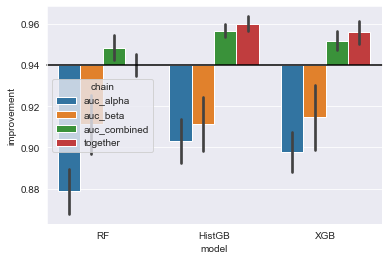

In [16]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd", hue='chain')

# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])
pass